`Remember to make a copy of this notebook !`

# Exercises for Session 4: Data Structuring 3

In this combined teaching module and exercise set, you will continue working with structuring data. 

In the last session, you were working with making operations on relatively clean data. However, before it is meaningful to make such operations, you will (as a data scientist) often have to do some very preliminary cleaning, involving for instance dealing with missings and duplicates as well as combining and restructuring larger sets of data. These are among the topics that we will be focusing on today.

The notebook is structured as follows:
1. Missings and Duplicated Data
2. Combining Data Sets
3. Split-Apply-Combine
4. Reshaping Data

In [1]:
# loading stuff

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

##  Part 1: Duplicates and Missings

In this section, we will use [this dataset](https://archive.ics.uci.edu/ml/datasets/Adult) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.html) to practice some basic operations on pandas dataframes. This is an extract from the US Census containing almost 50,000 rows of individual-level micro data from 1994.


> **Ex. 4.1.1:** This link `'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'` leads to a comma-separated file with income data from a US census. Load the data into a pandas dataframe and show the 25th to 35th row.
>
> _Hint 1:_ There are no column names in the dataset. Use the list `['age','workclass', 'fnlwgt', 'educ', 'educ_num', 'marital_status', 'occupation','relationship', 'race', 'sex','capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'wage']` as names. 
>
> _Hint 2:_ When you read in the csv, you might find that pandas includes whitespace in all of the cells. To get around this include the argument `skipinitialspace = True` to `read_csv()`. 

In [2]:
### BEGIN SOLUTION
url = f'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

labels = ['age','workclass', 'fnlwgt', 'educ', 'educ_num', 'marital_status', 'occupation','relationship', 'race', 'sex','capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'wage']

df_census = pd.read_csv(url, header=None, skipinitialspace = True, names=labels)
df_census.iloc[24:35]
### END SOLUTION

,age,workclass,fnlwgt,educ,educ_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage
24,59,Private,109015,HS-grad,9,Divorced,Tech-support,Unmarried,White,Female,0,0,40,United-States,<=50K
25,56,Local-gov,216851,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States,>50K
26,19,Private,168294,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
27,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
28,39,Private,367260,HS-grad,9,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,80,United-States,<=50K
29,49,Private,193366,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
30,23,Local-gov,190709,Assoc-acdm,12,Never-married,Protective-serv,Not-in-family,White,Male,0,0,52,United-States,<=50K
31,20,Private,266015,Some-college,10,Never-married,Sales,Own-child,Black,Male,0,0,44,United-States,<=50K
32,45,Private,386940,Bachelors,13,Divorced,Exec-managerial,Own-child,White,Male,0,1408,40,United-States,<=50K
33,30,Federal-gov,59951,Some-college,10,Married-civ-spouse,Adm-clerical,Own-child,White,Male,0,0,40,United-States,<=50K


###  Missing data

Often our data having information missing, e.g. one row lacks data on education for a specific person. In session_4 we learned about missing data type and got some simple tools to deal with the problem.

> **Ex. 4.1.2:** What is the missing value sign in this dataset? Replace all missing values with NA's understood by pandas. Then proceed to drop all rows containing any missing values with the `dropna` method. Store this new dataframe as `df_census_new`. How many rows are removed in this operation?
> 
> _Hint:_ NaN from NumPy might be useful. What you should discover here is that pandas indeed has native methods for dealing with missings.

In [3]:
from numpy import NaN

### BEGIN SOLUTION
df_census_new = df_census.replace('?', NaN).dropna()
print(f"We have dropped {len(df_census) - len(df_census_new)} rows")
print(f"This amounts to {round((len(df_census) - len(df_census_new))/len(df_census)*100,2)} % of the rows")
### END SOLUTION

We have dropped 2399 rows
This amounts to 7.37 % of the rows


###  Duplicated Data

Now we will turn our attention towards duplicated data and how to handle such observations.

> **Ex. 4.1.3:** Determine whether or not duplicated rows is a problem in the NOAA weather data and the US census data. You should come up with arguments from the structure of the rows.
>
> *Hint:* You can use the `load_weather()` function below to load weather data from a specific year.

In [4]:
def load_weather(year):
    
    url = f"ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/{year}.csv.gz"

    df_weather = pd.read_csv(url, 
                             header=None)        

    df_weather = df_weather.iloc[:,:4] 
    
    column_names = ['station', 'datetime', 'obs_type', 'obs_value']
    df_weather.columns = column_names 
    
    df_weather['obs_value'] = df_weather['obs_value'] / 10 
    
    selection_tmax = df_weather.obs_type == 'TMAX'
    df_select = df_weather.loc[selection_tmax]
    
    df_sorted = df_select.sort_values(by=['station', 'datetime'])
    df_reset = df_sorted.reset_index(drop=True)
    df_out = df_reset.copy()
            
    return df_out

In [5]:
### BEGIN SOLUTION
print(f"The share of duplicate observations in the weather data is {round((len(load_weather(1863)) - len(load_weather(1863).drop_duplicates(['station','datetime'])))/len(load_weather(1863))*100,2)} %")
print(f"The share of duplicate observations in the US census data is {round((len(df_census_new) - len(df_census_new.drop_duplicates()))/len(df_census_new)*100,2)} %")
### END SOLUTION

The share of duplicate observations in the weather data is 0.0 %
The share of duplicate observations in the US census data is 0.08 %


## Part 2: Combining Data Sets

Below we hear about how different datasets can be combined into one, by merging on overlapping information that exists in both datasets. If you want to know more then you can look up Chapter 8, section 8.2 in Python for Data Analysis, 2ed.

In this exercise will only be dealing with one-to-one joins. This is a type of merge where there is only one row with a given merge key in each data frame. However, you may encounter situations where there are multiple rows that share the value of a merge key. In this situation, you may perform a one-to-many join or a many-to-many join that forms a Cartesian product of your rows. You can read more about these types of merges by visiting the Jake van der Plass [link](https://jakevdp.github.io/PythonDataScienceHandbook/03.07-merge-and-join.html) or looking into PDA, section 8.2.

We now continue with structuring weather data. Use the function `load_weather()` for fetching and structuring weather data that you also used above.

> **Ex. 4.2.1:** Get the processed data from years 1870-1875 as a list of DataFrames. Generate a variable that denotes the year that the observations belong to. Convert the list into a single DataFrame by concatenating vertically. 

In [6]:
### BEGIN SOLUTION
my_list = []
for year in range(1870,1876):
    df = load_weather(year)
    df['year'] = year
    my_list.append(df)

df_weather = pd.concat(my_list, axis=0)
### END SOLUTION

## Part 3: Split-Apply-Combine

Often we need to process information for a given individual, point in time etc. Instead of writing a loop over all the subsets of the data, we can use a more clever approach. Below we introduce the split-apply-combine framework and show how we can leverage it in pandas. If you want to know more then you can look up Chapter 10 in Python for Data Analysis, 2ed.

We continue with the exercise that analyzes NOAA data. This time we are going to **read the weather data from a csv file** located in this assignment directory instead of trying to request the website. The file is called `'weather_data_1870-1875.csv'` and consists of weather data for the period 1870-1875. Specifically, the csv file contains a dataframe which has been constructed by concatenating the _non-processed_ data from 1870-1875.

> **Ex. 4.3.1:** Someone has writen the code below. They need your help to **rewrite parts of the function**. In particular, you need to do the following:
>0. 
>1. Rename the function to `process_weather` instead of `load_weather`. 
>2. The function should now  take a `dataframe` as input. 
>3. Consider whether `df_weather.iloc[:, :4]` is necessary for the weather data loaded from  the csv file. The documentation string should also be rewritten appropriately. 
>4. The function contains a sorting step. **Change it so that it first sorts by _station_, then by _datetime_. The sorting should be ascending for _station_ and descending for _datetime_.** 
>5. The function need to read the .csv file `'weather_data_1870-1875.csv'` instead of downloading it from a url. Load it into a pandas dataframe, apply the `process_weather` function, and store the result in the variable `df_weather_period`.

```python
import pandas as pd

def load_weather(year):
    
    '''
    This functions loads the data for selected year and then structures and cleans it.
    - Structuring includes removing unused columns, renaming and selecting only observations 
    of maximum temperature. 
    - Cleaning includes inserting missing decimal, sorting and resetting index.
    '''
    url = f"ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/{year}.csv.gz"
    
    # loads the data
    df_weather = pd.read_csv(url, header=None)\
                    .iloc[:,:4] 
    
    # structure and clean data using methods chaining
    # note that the original columns now are strings when loading the csv file
    # and not integers as when downloading the data
    df_out = \
        df_weather\
            .rename(columns={'0': 'station', '1': 'datetime', '2': 'obs_type', '3': 'obs_value'})\
            .query("obs_type == 'TMAX'")\
            .assign(obs_value=lambda df: df['obs_value']/10)\
            .sort_values(by=['station', 'datetime'])\
            .reset_index(drop=True)\
            .copy() 

    # area process
    df_out['area'] = df_out['station'].str[0:2]
    
    # datetime process
    df_out['datetime_dt'] = pd.to_datetime(df_out['datetime'], format = '%Y%m%d')
    df_out['month'] = df_out['datetime_dt'].dt.month
    df_out['year'] = df_out['datetime_dt'].dt.year
    
    return df_out
```

In [7]:
### BEGIN SOLUTION
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns

def process_weather(df_weather):   
    
    '''
    This functions structures and cleans weather data downloaded from  ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/.
    - Structuring includes renaming and selecting only observations 
    of maximum temperature. 
    - Cleaning includes inserting missing decimal, sorting.
    '''

    # structure and clean data using methods chaining
    # note that the original columns now are strings and not integers as when downloading the data
    df_out = \
        df_weather\
            .rename(columns={'0': 'station', '1': 'datetime', '2': 'obs_type', '3': 'obs_value'})\
            .query("obs_type == 'TMAX'")\
            .assign(obs_value=lambda df: df['obs_value']/10)\
            .sort_values(by=['station', 'obs_value'], ascending=[True, False])\
            .reset_index(drop=True)\
            .copy() 
    
    # area process
    df_out['area'] = df_out['station'].str[0:2]
    
    # datetime process
    df_out['datetime_dt'] = pd.to_datetime(df_out['datetime'], format = '%Y%m%d')
    df_out['month'] = df_out['datetime_dt'].dt.month
    df_out['year'] = df_out['datetime_dt'].dt.year 

    return df_out

df_weather = pd.read_csv('weather_data_1870-1875.csv')
df_weather_period = process_weather(df_weather)

### END SOLUTION

*Note:* The Split-Apply-Combine method uses `.groupby()` which is a method of pandas dataframes, meaning we can call it like so: `data.groupby('colname')`. The method groups your dataset by a specified column, and applies any following changes within each of these groups. For a more detailed explanation see [this link](https://www.tutorialspoint.com/python_pandas/python_pandas_groupby.htm). The [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) might also be useful.

> **Ex. 4.3.2:** Compute the mean and median maximum daily temperature for each month-year-station pair on the dataframe `df_weather_period` from last exercise by using the _split-apply-combine_ procedure. Store the results in new columns `tmax_mean` and `tmax_median`.

In [8]:
### BEGIN SOLUTION
df_weather_period['tmax_mean'] = df_weather_period.groupby(['month', 'year', 'station'])['obs_value'].transform('mean')
df_weather_period['tmax_median'] = df_weather_period.groupby(['month', 'year', 'station'])['obs_value'].transform('median')
### END SOLUTION

> **Ex. 4.3.3:** Plot the monthly max, min, mean, first and third quartiles for maximum temperature for our station with the ID _'CA006110549'_ for the years 1870-1875. 

> *Hint*: the method `describe` computes all these measures.

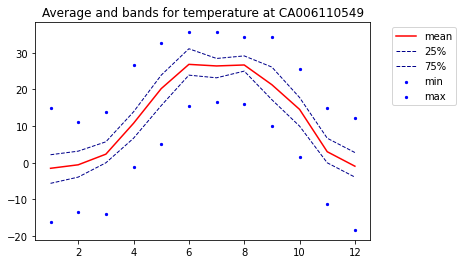

In [9]:
# ### BEGIN SOLUTION

# Use describe() to collapse the data
plot_data = df_weather_period\
                .query("station == 'CA006110549'")\
                .groupby('month')\
                .describe()\
                .obs_value\
                .reset_index()

# This dict contains a lot of info about each line in the figure            
figure_params = {
    'mean': {'color': 'red', 'label':'mean'},
    'min': {'color': 'blue', 'label':'min', 's': 5},
    'max': {'color': 'blue', 'label': 'max', 's': 5},
    '25%': {'color': 'darkblue', 'label': '25%', 'linestyle': 'dashed', 'linewidth': 1},
    '75%': {'color': 'darkblue', 'label':'75%', 'linestyle': 'dashed', 'linewidth': 1}
}

fig, ax = plt.subplots()
# For each line we want to draw
for line in ['mean', 'min', 'max', '25%', '75%']:
    if line in ['min', 'max']: # These should be scatter plots
        ax.scatter(plot_data['month'], plot_data[line], **figure_params[line])
    else: # These are line plots  
        ax.plot(plot_data['month'], plot_data[line], **figure_params[line])

ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
ax.set_title("Average and bands for temperature at CA006110549")
plt.show()
fig.tight_layout()
fig.savefig('station_data_plot.png')
### END SOLUTION

> **Ex. 4.3.4:** Use the station location data, which is located in this directory, to merge station locations onto `df_weather_period`. The file with station location data is called  `ghcnd-stations.txt`.  Store the result in the variable `final_data`. 

> _Hint:_ The location data have the folllowing format, 

```
------------------------------
Variable   Columns   Type
------------------------------
ID            1-11   Character
LATITUDE     13-20   Real
LONGITUDE    22-30   Real
ELEVATION    32-37   Real
STATE        39-40   Character
NAME         42-71   Character
GSN FLAG     73-75   Character
HCN/CRN FLAG 77-79   Character
WMO ID       81-85   Character
------------------------------
```

> *Hint*: The station information has fixed width format - does there exist a pandas reader for that?

In [10]:
### BEGIN SOLUTION
fname = 'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt'
cnames = ['station', 'lat', 'lon', 'elevation', 'state', 'name', 'gsn_flag', 'hcn-crn_flag', 'wmo_id']

# Load data 
locations = pd.read_fwf(fname, names=cnames)

# Merge
final_data = df_weather_period.merge(locations, on='station')
### END SOLUTION

##  Bonus Exercises

If you want to practice *split-apply-combine* a bit more before proceeding, we have generated two additional exercises that use the US census data from Part 1. In order to solve this exercise, you should use `df_census_new` which you generated in a previous exercise.

> **Ex. 4.3.5:** (_Bonus_) Is there any evidence of a gender-wage-gap in the data? Create a table showing the percentage of men and women earning more than 50K a year.

In [11]:
### BEGIN SOLUTION
df_census_new['HighWage'] = (df_census_new['wage'] == '>50K').astype(int)
df_census_new[['sex', 'HighWage']].groupby('sex').mean()
### END SOLUTION

,HighWage
sex,
Female,0.113678
Male,0.313837


> **Ex. 4.3.6:** (_Bonus_) Group the data by years of education (`educ_num`) and marital status. Now plot the share of individuals who earn more than 50K for the two groups 'Divorced' and 'Married-civ-spouse' (normal marriage). Your final result should look like this: 

![](examplefig.png)

> _Hint:_ remember the `.query()` method is extremely useful for filtering data.

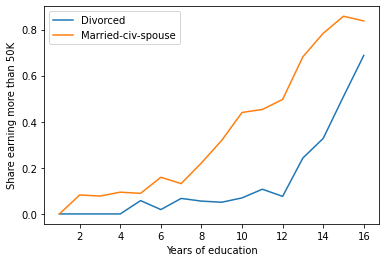

In [12]:
### BEGIN SOLUTION
df_census_new[['marital_status', 'HighWage', 'educ_num']]\
        .groupby(['marital_status', 'educ_num'])\
        .mean()\
        .reset_index()\
        .query("marital_status == 'Divorced' | marital_status == 'Married-civ-spouse'")\
        .set_index('educ_num')\
        .groupby('marital_status')\
        .HighWage\
        .plot()

plt.xlabel('Years of education')
plt.ylabel('Share earning more than 50K')
plt.legend()
### END SOLUTION

## Part 4: Reshaping  Dataframes

Often we have data that comes in a format that does not fit our purpose. If you want to know more then you can look up Chapter 8, section 8.3 in Python for Data Analysis, 2ed.

In this exercise, we continue working with the NOAA data.

> **Ex. 4.4.1:** For which months was the temperature in general (i.e. use the mean) lower in 1870 vs. 1875?
>
> *Hint:* you may use `unstack`.


In [13]:
### BEGIN SOLUTION
split_var = ['year', 'month']
apply_var = 'obs_value'
types = ['mean']

yearly_data = final_data.groupby(split_var)[apply_var].describe()[types].unstack()

for month in range(0,12):
    if yearly_data.iloc[0,month]>yearly_data.iloc[5,month]:
        print(f"In month {month+1}, it was warmer in 1870 than in 1875")
    else:
        print(f"In month {month+1}, it was warmer in 1875 than in 1870")
### END SOLUTION

In month 1, it was warmer in 1870 than in 1875
In month 2, it was warmer in 1870 than in 1875
In month 3, it was warmer in 1870 than in 1875
In month 4, it was warmer in 1870 than in 1875
In month 5, it was warmer in 1870 than in 1875
In month 6, it was warmer in 1870 than in 1875
In month 7, it was warmer in 1870 than in 1875
In month 8, it was warmer in 1875 than in 1870
In month 9, it was warmer in 1870 than in 1875
In month 10, it was warmer in 1870 than in 1875
In month 11, it was warmer in 1870 than in 1875
In month 12, it was warmer in 1870 than in 1875
